# Bank Account Fraud Detection (NeurIPS 2022)

## Data processing project - 7th Semester
### Team: Than Van Hong Son, Le Viet Hung

## Part 0: Setup Environments

In [8]:
!pip install plotly
!pip install lofo-importance
!pip install imblearn
!pip install scikit-learn

In [11]:
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from lofo import LOFOImportance, Dataset, plot_importance

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Bidirectional
# from imblearn.over_sampling import SMOTE
# from catboost import CatBoostClassifier, Pool
# import shap 


# imports for neural network
import tensorflow as tf
from tensorflow import keras

## Part 1: Exploratory Data Analysis

#### Import dataset

In [13]:
ba_df = pd.read_csv('Payment system/bank_account_fraud_dataset_archive/Base.csv')

#### Overview the status of fraud and normal

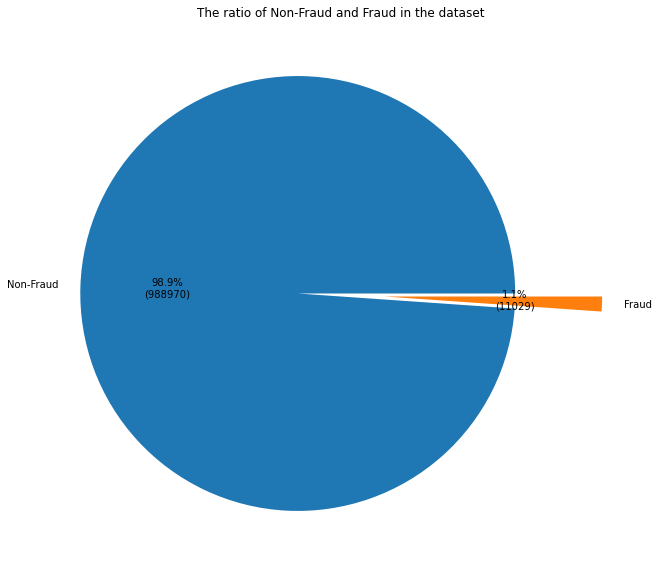

In [53]:
def func(value, total):
    y = value*sum(total)/100
    return "{:.1f}%\n({})".format(value, int(y))

labels = ['Non-Fraud', 'Fraud']
values = ba_df['fraud_bool'].value_counts() / ba_df['fraud_bool'].shape[0]
total_normal = ba_df[ba_df['fraud_bool'] == False].shape[0]
total_fraudulent = ba_df[ba_df['fraud_bool'] == True].shape[0]
y = [total_normal, total_fraudulent]

fig, ax = plt.subplots(figsize =(12, 10))
ax.pie(
    y, 
    autopct = lambda pct: func(pct, y),
    labels=labels, 
    explode =[0.2, 0.2], 
    shadow = False)
plt.title("The ratio of Non-Fraud and Fraud in the dataset")
plt.plot();

#### Quick review

In [52]:
ba_df.head(5).T

,0,1,2,3,4
fraud_bool,1,1,1,1,1
income,0.9,0.9,0.9,0.9,0.9
name_email_similarity,0.166828,0.296286,0.044985,0.159511,0.596414
prev_address_months_count,-1,-1,-1,-1,-1
current_address_months_count,88,144,132,22,218
customer_age,50,50,40,50,50
days_since_request,0.020925,0.005418,3.108549,0.019079,0.004441
intended_balcon_amount,-1.331345,-0.816224,-0.755728,-1.205124,-0.773276
payment_type,AA,AB,AC,AB,AB
zip_count_4w,769,366,870,810,890


#### Basic statistics

In [55]:
ba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [57]:
ba_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.562696,0.290343,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.493694,0.289125,1.434550e-06,0.225216,0.492153,0.755567,0.999999
prev_address_months_count,1000000.0,16.718568,44.046230,-1.000000e+00,-1.000000,-1.000000,12.000000,383.000000
current_address_months_count,1000000.0,86.587867,88.406599,-1.000000e+00,19.000000,52.000000,130.000000,428.000000
customer_age,1000000.0,33.689080,12.025799,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.025705,5.381835,4.036860e-09,0.007193,0.015176,0.026331,78.456904
intended_balcon_amount,1000000.0,8.661499,20.236155,-1.553055e+01,-1.181488,-0.830507,4.984176,112.956928
zip_count_4w,1000000.0,1572.692049,1005.374565,1.000000e+00,894.000000,1263.000000,1944.000000,6700.000000
velocity_6h,1000000.0,5665.296605,3009.380665,-1.706031e+02,3436.365848,5319.769349,7680.717827,16715.565404


## Part 2: Data Processing, Feature Engineering for Fraud Detection of Bank Account Applications